### Collaborative Filtering Trail Recommender

For this recommendation system, the reviews of all trails were gathered and used to predict the ratings of trails that a user has not rated yet. By doing so, we are able to recommend a trail to a user based on our predicted rating.

#### Where is the data coming from?

The data was scraped from AllTrails.com using BeautifulSoup and Selenium. A list of 1418 trails in Arizona was gathered. The reviews of each trail were then collected and exported to a SQL database. This was a bit challenging, as the only way to load more reviews was to click a button that would populate more reviews. This action would load 30 more reviews each time, so it had to be done repeatedly. As such, Selenium was used to located the button on click it (total reviews/30) times. For this demonstration, the class created to extract the data from the webpages will not be used. The data will be imported from the SQL database

In [91]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

conn = psycopg2.connect("dbname='az_trail_recommender' user='josephdoperalski' host='localhost'")
cur = conn.cursor()
query_reviews = '''SELECT * FROM trail_reviews'''
reviews = sqlio.read_sql_query(query_reviews, conn)
reviews.drop('index', axis = 1, inplace = True)
reviews.head(10)

,review_id,trail_id,trail_name,user,rating,body
0,0_0,0,Camelback Mountain via Echo Canyon Trail,/members/arron-hampton,5,Super hard. It’s all scrambling after about 1/...
1,0_1,0,Camelback Mountain via Echo Canyon Trail,/members/brian-white-18,4,First time hiking this trail and it did not di...
2,0_2,0,Camelback Mountain via Echo Canyon Trail,/members/arron-hampton,5,A must do for the 360 degree views of the Vall...
3,0_3,0,Camelback Mountain via Echo Canyon Trail,/members/maddie-wilson,5,Very challenging and fun!
4,0_4,0,Camelback Mountain via Echo Canyon Trail,/members/giselle-johnson,5,Went when it was slightly rainy and enjoyed th...
5,0_5,0,Camelback Mountain via Echo Canyon Trail,/members/mark-mckeever-1,5,"Very nice hike. At 62, it was a challenge. Saw..."
6,0_6,0,Camelback Mountain via Echo Canyon Trail,/members/shaun-otoole,5,Amazing Trail. More treacherous than the photo...
7,0_7,0,Camelback Mountain via Echo Canyon Trail,/members/katie-plew,5,Great workout definitely worth the view!
8,0_8,0,Camelback Mountain via Echo Canyon Trail,/members/ronald-catague,5,physically demanding and definitely not for fi...
9,0_9,0,Camelback Mountain via Echo Canyon Trail,/members/wissam-baghdadi,5,"I started at 10:30 am, I was surprised to see ..."


From here, some manipulation had to be done. The review_id, trail_name, and body all had to be dropped. This is done as the model used to create our recommendation engine only requires the trail_id, user, and rating. The user column was also altered so as to remove the '/members/' in front of the usernames. Running the cell below outputs the format for the dataframe that will be fed into the model.

In [92]:
import sys
sys.path.append('..')
from hiking_data_v1 import ReviewsShaper

rev_shaper = ReviewsShaper(reviews)
rev_shaper.fix_column_data()
rev_shaper.user2user()
df = rev_shaper.user2user_df
df.head(20)

,user,trail_id,rating
0,007297,14,5.0
1,0scararn0ld,39,5.0
2,0scararn0ld,311,5.0
3,101southdrum-user,584,5.0
4,1337killer,248,5.0
5,139ss6,25,5.0
6,1433jenn,1479,4.0
7,14burrito,0,5.0
8,14burrito,22,4.0
9,14burrito,94,4.0


#### How are recommendations made?

Let's take a step back. The point of this model is to predict the ratings for trails that a user has not yet rated. It does this by using information about how a given user has rated other trails and how a given trail is rated by other users. Our actual matrix would be a sparse matrix as there would be a lot of unknown values. It would look something like the one below.

In [93]:
sparse_mat = df.groupby(['user', 'trail_id'], as_index=False).agg({'rating':'mean'}).pivot('user', 'trail_id', 'rating')
print("matrix shape:", sparse_mat.shape, "\n", "missing values:",sum(sparse_mat.isnull().sum()))
sparse_mat.head(20)

matrix shape: (34878, 1414) 
 missing values: 49247057


trail_id,0,1,2,3,4,5,6,7,8,9,...,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871
user,,,,,,,,,,,,,,,,,,,,,
007297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0scararn0ld,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101southdrum-user,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1337killer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139ss6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1433jenn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14burrito,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14erbound,4.0,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15-dollars-40-dollars,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ugly, right? While this is a truncated version, There are actually 34878 rows, which would represent 34878 users and 1414 columns representing the trails. In all, 49247057 of the 49317492 values are missing, which represents more than 99% of the matrix. This is more sparse than we'd like. Making predictions with this many unknown values would not be reliable. The histogram below shows that the vast majority of users have only left one review. For the sake of a reliable recommendation, we'll remove those users that have had less than 5 reviews from our collaborative filtering recommendation system. For those users, we would face the cold start problem and a content-based recommendation system would be more appropriate.

median ratings: 1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24b5df60>]],
      dtype=object)

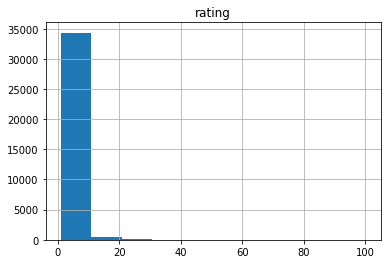

In [94]:
ratings_count = df.groupby('user', as_index=False).agg({'rating':'count'})
print("median ratings:", ratings_count['rating'].median())
ratings_count.hist(column = 'rating')

In [112]:
final_df = df[df['user'].isin(ratings_count[ratings_count['rating'] >= 5]['user'])]

In [114]:
sparse_final = final_df.groupby(['user', 'trail_id'], as_index=False).agg({'rating':'mean'}).pivot('user', 'trail_id', 'rating')
print(" matrix shape:", sparse_final.shape, "\n", "missing values:",sum(sparse_final.isnull().sum()), "\n", "percent missing:", sum(sparse_final.isnull().sum())/(sparse_final.shape[0]*sparse_final.shape[1])*100)
sparse_final.head(20)

 matrix shape: (2623, 1350) 
 missing values: 3518075 
 percent missing: 99.35118114683497


trail_id,0,1,2,3,4,5,6,7,8,9,...,1858,1861,1862,1863,1865,1866,1868,1869,1870,1871
user,,,,,,,,,,,,,,,,,,,,,
14burrito,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14erbound,4.0,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1mary,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4billh,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7shan,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a-alioto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a-ba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a-g-96,5.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron-cook-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That's a little bit better. We'll work with what we've got. We now have our original matrix, which we will call R, of size n $\times$ m . This matrix can actually be represented as the dot product of three smaller matrices that we'll denote with M, sigma, and U<sup>T</sup>. This is known as SVD. Briefly, M is a matrix representing user trends, sigma is a diagonal matrix of singular values (useful for determing how much information is actually necessary), and U<sup>T</sup> is a matrix of trends of trails. Therefore R = M $\times$ sigma $\times$ U<sup>T</sup>. For simplicity, we'll merge sigma into M and U<sup>T</sup> so we now have R = M $\times$ U<sup>T</sup>. In order to predict ratings, we make this an optimization problem so that we are minimzing $\sum$(r<sub>ui</sub> -  p<sub>u</sub> $\times$ q<sub>i</sub>)<sup>2</sup>, where r represents the actual ratings, p represents a vector from M and q represents a vector from U<sup>T</sup>. Essentially, this is done by iteratively updating the values for p<sub>u</sub> and q<sub>i</sub> using stochastic gradient descent until a certain predecided threshold is reached.

Unknown values can then be inserted into our model. The specific model used for this project is SVD from the suprise module. The model was fit on the above data for each user and trail combination where a rating was present. Cells that had a missing value were fed into the model for a prediction. The output for the model is then a sorted list of trails with the highest predicted ratings for trails not yet rated by the user. 